In [1]:
# import packages
# sds:2020 Docker environment
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os
from matplotlib.colors import ListedColormap
from matplotlib.collections import PatchCollection

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) 

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

In [2]:
rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

In [3]:
df = pd.read_csv("https://github.com/supernovajon/qm/blob/main/Startups.csv?raw=true", header = 0, 
                 encoding = 'unicode_escape',low_memory=False)

In [4]:
df.describe()

,Research_and_Development,Administration,Marketing,Profit
count,50.00,50.00,50.00,50.00
mean,"73,721.62","121,344.64","211,025.10","112,012.64"
std,"45,902.26","28,017.80","122,290.31","40,306.18"
min,0.00,"51,283.14",0.00,"14,681.40"
25%,"39,936.37","103,730.88","129,300.13","90,138.90"
50%,"73,051.08","122,699.79","212,716.24","107,978.19"
75%,"101,602.80","144,842.18","299,469.08","139,765.98"
max,"165,349.20","182,645.56","471,784.10","192,261.83"


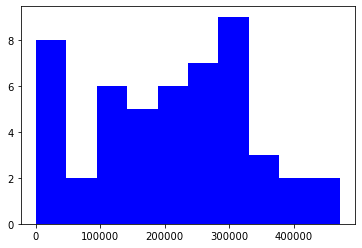

In [5]:
plt.hist(df['Marketing'],color = "blue")
plt.show()

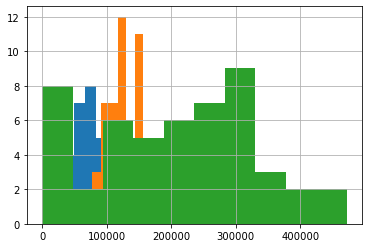

In [6]:
#no need to apply(np.log1p).hist()
df['Research_and_Development'].hist()
df['Administration'].hist()
df['Marketing'].hist()
plt.show()

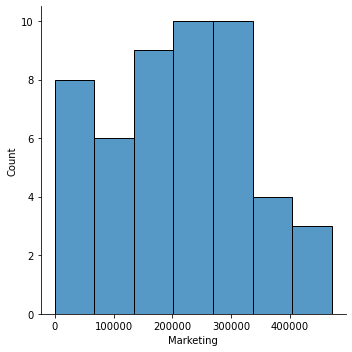

In [7]:
sns.displot(df['Marketing'])

#replace nan
df = df.replace(np.nan, 0)

to_log = ['R&D Spend', 'Administration', 'Marketing Spend','Profit']
df = df[to_log].applymap(lambda x: np.log(x+1))

<AxesSubplot:xlabel='Research_and_Development', ylabel='Profit'>

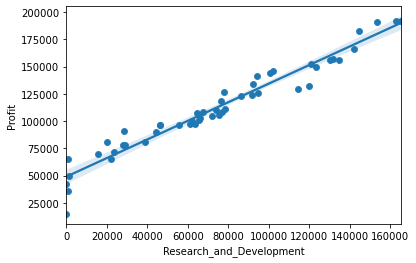

In [8]:
#plot it to give an overall view
sns.scatterplot(data=df, x=df['Research_and_Development'], y='Profit')
sns.regplot(data=df, x=df['Research_and_Development'], y='Profit')

In [9]:
scores = ['Research_and_Development','Administration','Marketing','Profit']
scores = df[scores]

Text(0.5, 1.0, 'Correlation Matrix')

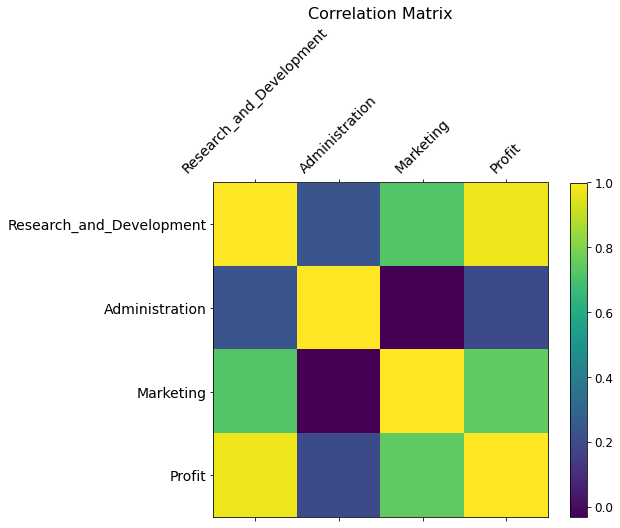

In [10]:
#correlation matrix
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(8, 6))
plt.matshow(scores.corr(), fignum=f.number)
plt.xticks(range(scores.shape[1]), scores.columns, fontsize=14, rotation=45)
plt.yticks(range(scores.shape[1]), scores.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=12)
plt.title('Correlation Matrix', fontsize=16)

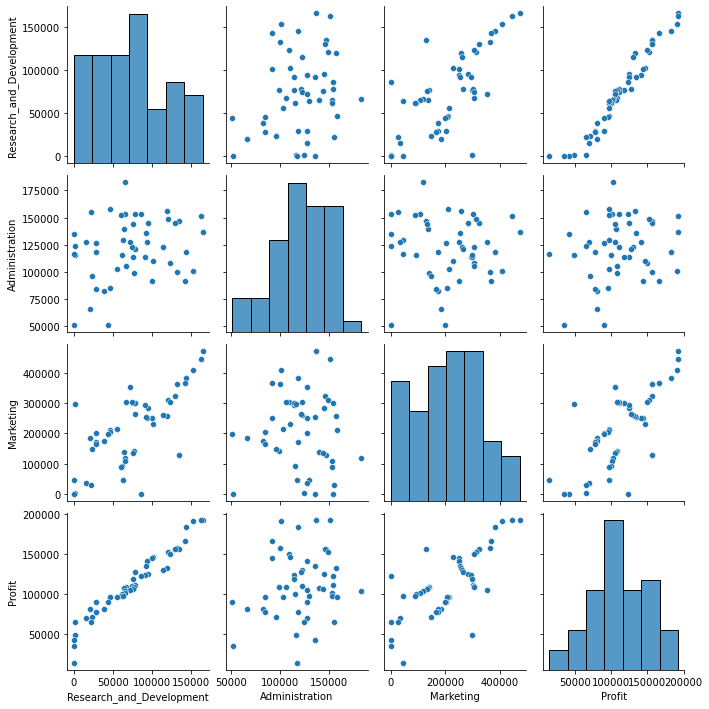

In [11]:
sns.pairplot(scores)

In [12]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [13]:
model = smf.ols(formula='Profit ~ Research_and_Development + Administration + Marketing', data=scores).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           4.53e-30
Time:                        23:31:05   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                 5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
Research_and_Development     0.8057      0.045     17.846      0.000       0.715       0.897
Administration              -0.0268      0.051     -0.526      0.602      -0.130       0.076
Marketing                    0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

In [15]:
def drop_column_using_vif_(X, thresh=5):
    while True:
        df_with_const = add_constant(X)
        vif_X = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_X = vif_X.drop('const')
        if vif_X.VIF.max() > thresh:
            index_to_drop = vif_X.index[vif_X.VIF == vif_X.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            X = X.drop(columns = index_to_drop) #X = X.drop(X.columns[index_to_drop], axis=1)
        else:
            break

    return X

In [16]:
scores_new = drop_column_using_vif_(scores.drop('Profit', axis=1))

In [17]:
scores_new.columns

Index(['Research_and_Development', 'Administration', 'Marketing'], dtype='object')

#Now we can fit a linear regression model after dealing with the multicollinearity. There are at least two different ways to forumlate a linear regression model using statsmodels.

Using statsmodels.api.formula.ols. A specific formula is needed.
Using statsmodels.api.OLS. You don't need to write the formula. Assign the y and X in the linear regression to the endog and exog parameters, respectively.
Now we use the statsmodels.api.OLS to build and fit a linear regression model.

In [18]:
model_a = sm.OLS(endog=scores[['Profit']], exog=sm.add_constant(scores_new)).fit()
model_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Fri, 29 Jan 2021   Prob (F-statistic):           4.53e-30
Time:                        23:31:05   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     5.012e+04   6572.353      7.626      0.000    3.69e+04    6.34e+04
Research_and_Development     0.8057      0.045     17.846      0.000       0.715       0.897
Administration              -0.0268      0.051     -0.526      0.602      -0.130       0.076
Marketing                    0.0272      0.016      1.655      0.105      -0.006       0.060
==============================================================================
Omnibus:                       14.838   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.442
Skew:                          -0.949   Prob(JB):                     2.21e-05
Kurtosis:                       5.586   Cond. No.                     1.40e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
#Train|Test, select 3 column
X = scores_new

In [20]:
y = df['Profit']

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
#33% left out of test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
print(f"Training data size: {X_train.shape[0],X_train.shape[1]}")
print(f"Training test size: {X_test.shape[0],X_test.shape[1]}")

Training data size: (33, 3)
Training test size: (17, 3)


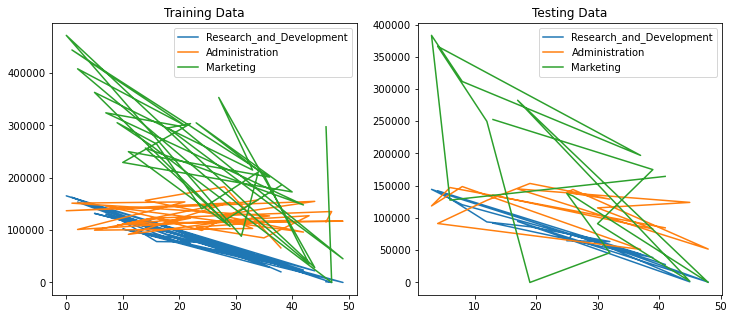

In [24]:
f,axes = plt.subplots(1,2, figsize=(12,5))
X_train.plot(ax=axes[0])
X_test.plot(ax=axes[1])
axes[0].set_title('Training Data')
axes[1].set_title('Testing Data');

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
model = LinearRegression()

In [27]:
model.fit(X_train,y_train)

LinearRegression()

In [28]:
test_predictions = model.predict(X_test)

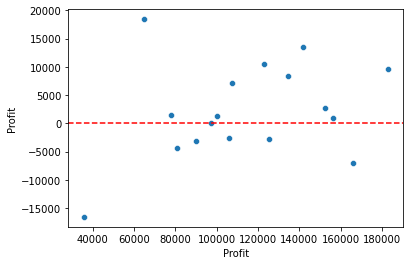

In [29]:
#evaluate residuals bcos visualising if this linear regression model is appropriate 
test_residuals = y_test - test_predictions
sns.scatterplot(x=y_test, y=test_residuals)
plt.axhline(y=0, color='r', ls='--')
#so here, no clear pattern (line or curve) on residuals, should look random indicates that the linear regression is appropriate

In [30]:
#evaluate performance of the model, use standard deviation which punishes the larger errors
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [31]:
df['Profit'].mean() #average profit value

112012.63920000002

In [32]:
np.sqrt(mean_squared_error(y_test, test_predictions))
#comparing this figure to the mean, it is small deviation from the mean which indicates more of the data is clustered about the mean

8500.40628458977

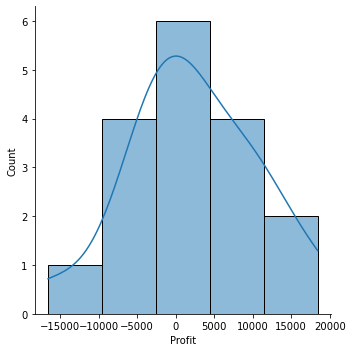

In [33]:
#distribution around 0
sns.displot(test_residuals, bins=5, kde=True)

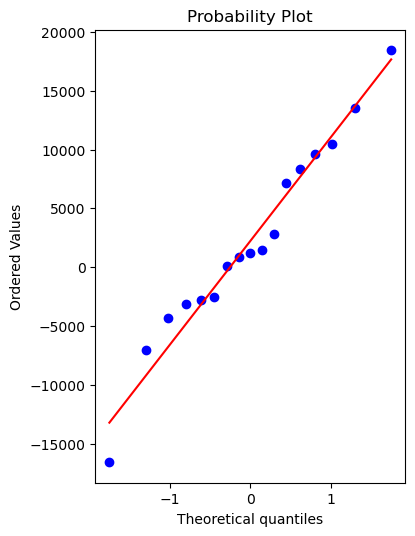

In [34]:
#if it is normally distributed for quantile
import scipy as sp
#create a fig and axis to plot on
fig, ax = plt.subplots(figsize=(4,6), dpi=100)
_ = sp.stats.probplot(test_residuals, plot=ax)

In [35]:
df_with_const = add_constant(X)
vif_X = pd.Series([variance_inflation_factor(df_with_const.values, i) 
                   for i in range(df_with_const.shape[1])], name= "VIF",
                  index=df_with_const.columns).to_frame()
vif_X = vif_X.drop('const')

In [36]:
vif_X.round(1)

,VIF
Research_and_Development,2.50
Administration,1.20
Marketing,2.30


In [37]:
from sklearn.datasets import load_digits
>>> digits = load_digits()

In [38]:
final_model = LinearRegression()
final_model.fit(X,y)

LinearRegression()

In [39]:
final_model.coef_

array([ 0.80571505, -0.02681597,  0.02722806])

In [40]:
#visually compare the prediction against the real values
y_ = final_model.predict(X)

In [41]:
clf = final_model
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.9481145113641924

In [42]:
clf.score(X_test, y_test)

0.9492192923202728

In [43]:
print("R-Square : " ,model.score(X_train,y_train))
print("R-Square : " ,model.score(X_test,y_test))

R-Square :  0.9481145113641924
R-Square :  0.9492192923202728


In [44]:
print("Training:"+str(clf.score(X_train,y_train)))
print("Test:"+str(clf.score(X_test,y_test)))
pred = clf.predict(X_train)

Training:0.9481145113641924
Test:0.9492192923202728


In [45]:
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.pyplot import figure

In [46]:
r2_score(y, y_)

0.9507459940683246

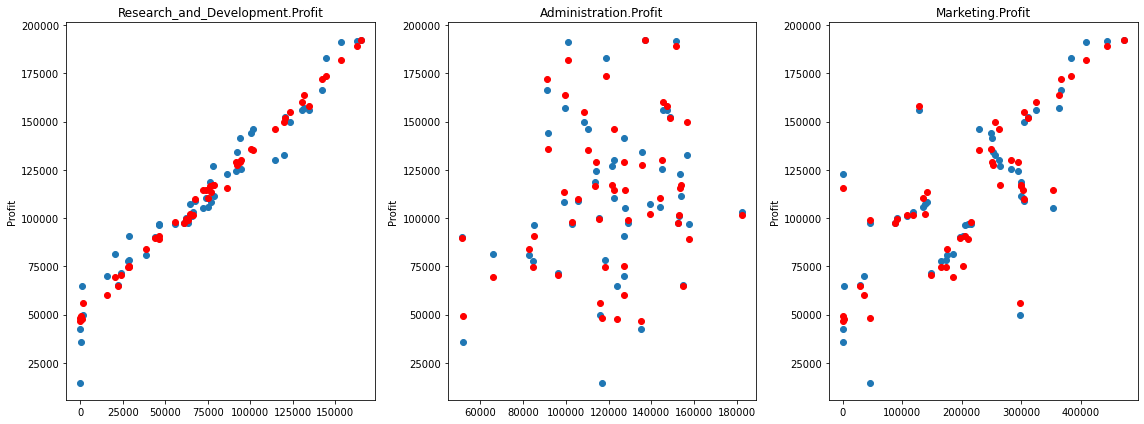

In [47]:
#to get predicted results against the real data
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(16,6))
axes[0].plot(scores['Research_and_Development'],scores['Profit'],'o')
axes[0].plot(scores['Research_and_Development'],y_,'o', color= 'red')
axes[0].set_ylabel("Profit")
axes[0].set_title("Research_and_Development.Profit")

axes[1].plot(scores['Administration'],scores['Profit'],'o')
axes[1].plot(scores['Administration'],y_,'o', color= 'red')
axes[1].set_ylabel("Profit")
axes[1].set_title("Administration.Profit")

axes[2].plot(scores['Marketing'],scores['Profit'],'o')
axes[2].plot(scores['Marketing'],y_,'o', color= 'red')
axes[2].set_ylabel("Profit")
axes[2].set_title("Marketing.Profit")
plt.tight_layout()

In [48]:
x = scores.iloc[:,:-1]  
T = np.matrix(x)
T.shape

(50, 3)

In [49]:
M1 = np.matmul(T.transpose(),T)
M1 = np.linalg.inv(M1)
M1.shape

(3, 3)

In [50]:
Ty = df.iloc[:,-1] 
Ty = np.matrix(Ty) 
Ty = Ty.T #transpose
Ty.shape

(50, 1)

In [51]:
M2 = np.matmul(T.transpose(),Ty)
M2.shape

(3, 1)

In [52]:
matrix = np.matmul(M1,M2)
matrix

matrix([[0.71795263],
        [0.32769472],
        [0.08217953]])

In [53]:
y_2 = np.matmul(T,matrix)
r2_score(Ty, y_2)

0.8884726564546346

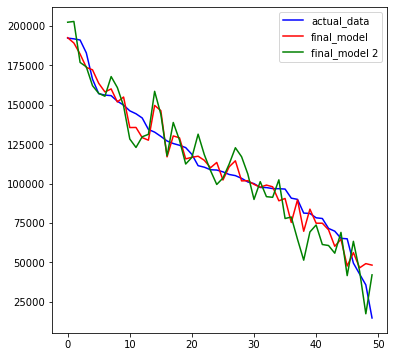

In [54]:
figure(num=3, figsize=(6, 6))
plt.plot(np.arange(50),y, color = "blue", label = 'actual_data') 
plt.plot(np.arange(50),y_, color = "red", label = 'final_model') 
plt.plot(np.arange(50),np.array(y_2), color = "green", label = 'final_model 2') 
plt.legend()
plt.show()